In [ ]:
!kaggle datasets download -d ttungl/adience-benchmark-gender-and-age-classification

adience-benchmark-gender-and-age-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name="adience-benchmark-gender-and-age-classification.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random

import tensorflow as tf
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import normalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
batch0 = pd.read_csv("./AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt",sep = "\t" )
batch1 = pd.read_csv("./AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt",sep = "\t")
batch2 = pd.read_csv("./AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt",sep = "\t")
batch3 = pd.read_csv("./AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt",sep = "\t")
batch4 = pd.read_csv("./AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt",sep = "\t")

In [ ]:
total_data = pd.concat([batch0, batch1, batch2, batch3, batch4], ignore_index=True)
print(batch0.shape)
print(total_data.shape)

(3446, 12)
(19370, 12)


In [ ]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,113445054@N07,11763777465_11d01c34ce_o.jpg,1322,"(25, 32)",m,1102,296,357,357,-15,0,59
1,113445054@N07,11763777465_11d01c34ce_o.jpg,1323,"(25, 32)",f,1713,580,325,325,-5,0,118
2,113445054@N07,11763777465_11d01c34ce_o.jpg,1324,"(15, 20)",f,1437,664,306,306,5,0,109
3,113445054@N07,11764005785_f21921aea6_o.jpg,1325,"(25, 32)",f,978,229,803,803,-20,-45,16
4,113445054@N07,11763728674_a41d99f71e_o.jpg,1326,"(25, 32)",m,1745,910,242,242,-10,0,55


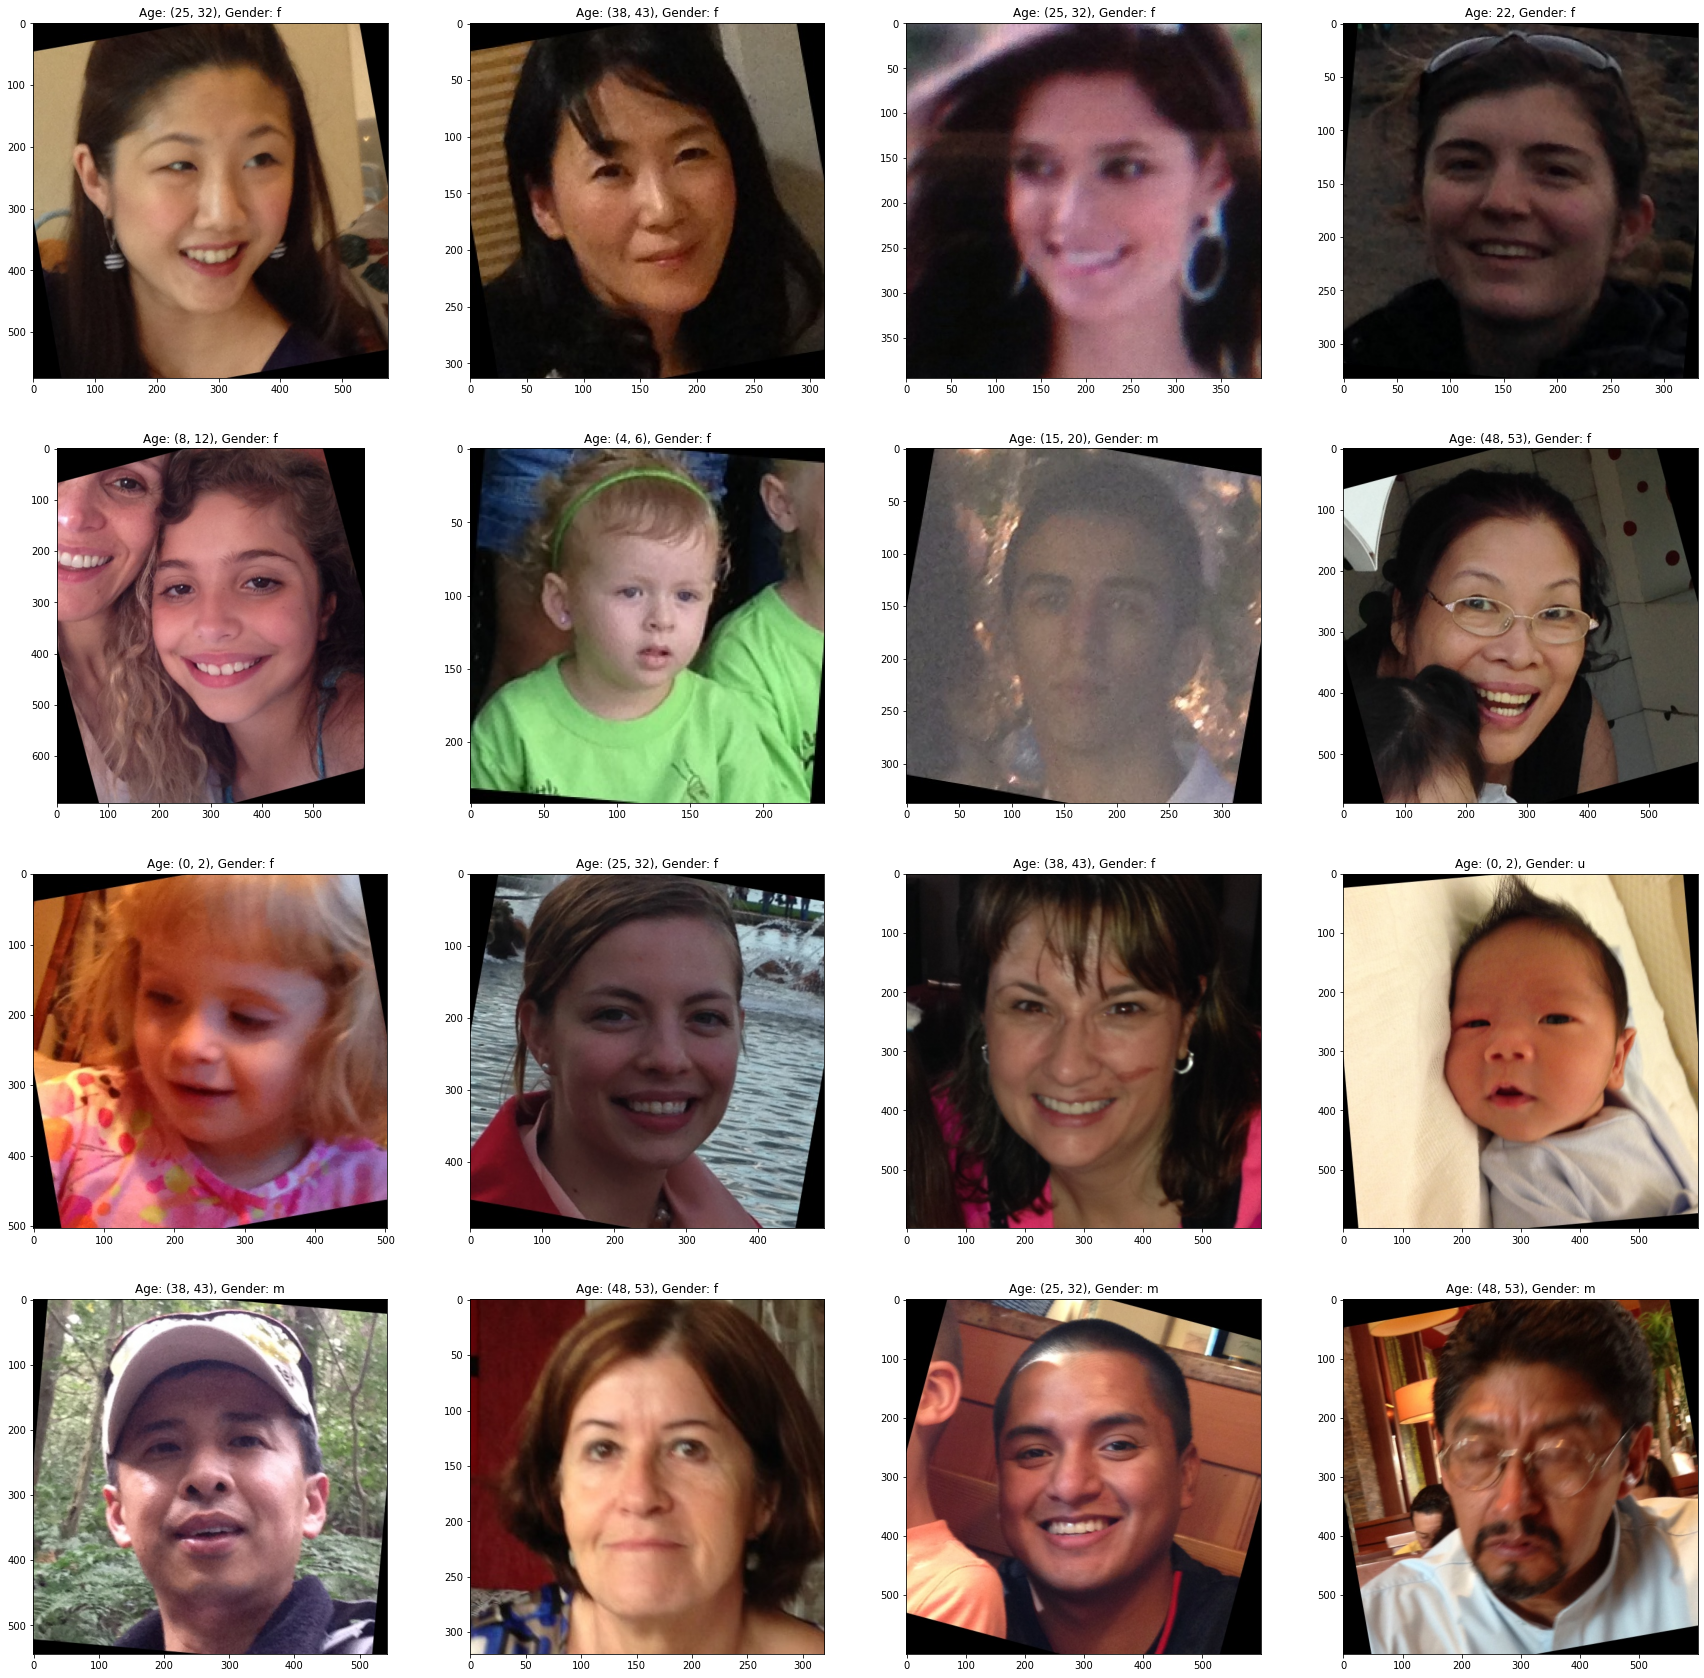

In [ ]:
images = []
for _ in range(16):
    sample_num = random.randint(0, len(total_data))
    im_name = total_data.iloc[sample_num].original_image
    im_path = os.path.join('./AdienceBenchmarkGenderAndAgeClassification/', 'faces',
str(total_data.iloc[sample_num].user_id), 'coarse_tilt_aligned_face.' + str(total_data.iloc[sample_num].face_id) + '.' + im_name)
    image = cv2.imread(im_path)
    age = total_data.iloc[sample_num].age
    gender = total_data.iloc[sample_num].gender
    n_col = 4
    n_rows = 4
    images.append((image, age, gender))
    
fig, axs = plt.subplots(ncols=n_col, nrows=n_rows, figsize=(30,30))
count = 0
for i in range(n_rows):
      for j in range(n_col):
        axs[i][j].imshow(cv2.cvtColor(images[count][0], cv2.COLOR_BGR2RGB))
        axs[i][j].set_title(f'Age: {images[count][1]}, Gender: {images[count][2]}')
        count+=1
plt.show()

In [ ]:

df=pd.DataFrame()
df = total_data[['age', 'gender']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
dtypes: object(2)
memory usage: 302.8+ KB


In [ ]:
img_path = []
for row in total_data.iterrows():
    path = "./AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df.insert(0,'image_path',img_path)

In [ ]:
df.head()

,image_path,age,gender
0,./AdienceBenchmarkGenderAndAgeClassification/f...,"(25, 32)",m
1,./AdienceBenchmarkGenderAndAgeClassification/f...,"(25, 32)",f
2,./AdienceBenchmarkGenderAndAgeClassification/f...,"(15, 20)",f
3,./AdienceBenchmarkGenderAndAgeClassification/f...,"(25, 32)",f
4,./AdienceBenchmarkGenderAndAgeClassification/f...,"(25, 32)",m


In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [ ]:
df = df.dropna()
data = df[df.gender != 'u'].copy()


In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

In [ ]:
data['age'] = data['age'].apply(lambda age: age_to_label_map[age])
data['gender'] = data['gender'].apply(lambda g: gender_to_label_map[g])

data.head()

,image_path,age,gender
0,./AdienceBenchmarkGenderAndAgeClassification/f...,4,1
1,./AdienceBenchmarkGenderAndAgeClassification/f...,4,0
2,./AdienceBenchmarkGenderAndAgeClassification/f...,3,0
3,./AdienceBenchmarkGenderAndAgeClassification/f...,4,0
4,./AdienceBenchmarkGenderAndAgeClassification/f...,4,1


In [ ]:
X = data[['image_path']]
Y_gender = data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X, Y_gender, test_size=0.25, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (13089, 1)
Test data shape (4363, 1)


In [ ]:

Y_age = data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_age_train, y_age_test = train_test_split(X, Y_age, test_size=0.25, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (13089, 1)
Test data shape (4363, 1)


In [ ]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].image_path)
    image = image.resize((228, 228))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].image_path)
    image = image.resize((228, 228))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (13089, 228, 228, 3)
Test images shape (4363, 228, 228, 3)


In [ ]:
leaky_relu_alpha = 0.1

model = Sequential()

# 1st Conv Layer
model.add(Conv2D(96, (7,7), strides=(3, 3), padding='same', input_shape=(228, 228, 3)))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 2nd Conv Layer
model.add(Conv2D(96, (3,3), strides=(2, 2), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(LayerNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 3rd Conv Layer
model.add(Conv2D(96, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 4th Conv Layer
model.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(LayerNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 5th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# 6th Conv Layer
model.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())

# Max Pooling with Dropout Layer
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# 1st FC Dense Layer
model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 2nd FC Dense Layer
model.add(Dense(512))
model.add(LeakyReLU(alpha=leaky_relu_alpha))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Final Dense Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 76, 76, 96)        14208     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 76, 76, 96)        0         
                                                                 
 batch_normalization (BatchN  (None, 76, 76, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 96)        83040     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 38, 38, 96)        0         
                                                                 
 layer_normalization (LayerN  (None, 38, 38, 96)       192       
 ormalization)                                          

In [ ]:
# model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# history = model.fit(train_images, y_train, batch_size=32, epochs=5, validation_data=(test_images, y_test), callbacks=[callback])

model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(learning_rate=0.0001, decay = 0.001 / 64),
             metrics=[keras.metrics.BinaryAccuracy()])

model.fit(train_images, 
          y_gender_train,
          epochs = 15, 
          batch_size = 32,
          validation_data=(test_images, y_gender_test)
          )

Epoch 1/15
410/410 [==============================] - 950s 2s/step - loss: 0.7401 - binary_accuracy: 0.6379 - val_loss: 0.5561 - val_binary_accuracy: 0.7114
Epoch 2/15
410/410 [==============================] - 936s 2s/step - loss: 0.6418 - binary_accuracy: 0.6845 - val_loss: 0.5245 - val_binary_accuracy: 0.7463
Epoch 3/15
410/410 [==============================] - 938s 2s/step - loss: 0.5812 - binary_accuracy: 0.7185 - val_loss: 0.5153 - val_binary_accuracy: 0.7552
Epoch 4/15
410/410 [==============================] - 919s 2s/step - loss: 0.5222 - binary_accuracy: 0.7507 - val_loss: 0.4607 - val_binary_accuracy: 0.7834
Epoch 5/15
410/410 [==============================] - 922s 2s/step - loss: 0.4735 - binary_accuracy: 0.7776 - val_loss: 0.4290 - val_binary_accuracy: 0.8040
Epoch 6/15
410/410 [==============================] - 919s 2s/step - loss: 0.4338 - binary_accuracy: 0.8031 - val_loss: 0.3973 - val_binary_accuracy: 0.8178
Epoch 7/15
278/410 [===================>..........] - ETA:

KeyboardInterrupt: ignored

In [ ]:
leaky_relu_alpha = 0.15

model_age = Sequential()

# 1st Conv Layer
model_age.add(Conv2D(96, (7,7), strides=(3, 3), padding='same', input_shape=(228, 228, 3)))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())

# 2nd Conv Layer
model_age.add(Conv2D(96, (3,3), strides=(2, 2), padding='same'))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(LayerNormalization())

# Max Pooling with Dropout Layer
model_age.add(MaxPooling2D(pool_size = (2, 2)))
model_age.add(Dropout(0.2))

# 3rd Conv Layer
model_age.add(Conv2D(96, (3,3), strides=(1, 1), padding='same'))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())

# 4th Conv Layer
model_age.add(Conv2D(128, (3,3), strides=(1, 1), padding='same'))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(LayerNormalization())

# Max Pooling with Dropout Layer
model_age.add(MaxPooling2D(pool_size = (2, 2)))
model_age.add(Dropout(0.2))

# 5th Conv Layer
model_age.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())

# 6th Conv Layer
model_age.add(Conv2D(256, (3,3), strides=(1, 1), padding='same'))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())

# Max Pooling with Dropout Layer
model_age.add(MaxPooling2D(pool_size = (2, 2)))
model_age.add(Dropout(0.2))

# 1st FC Dense Layer
model_age.add(Flatten())
model_age.add(Dense(512))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())
model_age.add(Dropout(0.3))

# 2nd FC Dense Layer
model_age.add(Dense(512))
model_age.add(LeakyReLU(alpha=leaky_relu_alpha))
model_age.add(BatchNormalization())
model_age.add(Dropout(0.3))

# Final Dense Layer
model_age.add(Dense(units=8, activation='softmax'))


model_age.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 76, 76, 96)        14208     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 76, 76, 96)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 76, 76, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 38, 38, 96)        83040     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 38, 38, 96)        0         
                                                                 
 layer_normalization_4 (Laye  (None, 38, 38, 96)       192       
 rNormalization)                                      

In [ ]:
model.save('gender_classification.h5')

In [ ]:

from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('/Saved_Model/age_estimation.h5',
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0.0001,
                         patience = 20,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                             factor = 0.01,
                             patience = 20,
                             verbose = 1,
                             min_delta = 0.00001)

my_callbacks = [checkpoint, earlystop, reduce_lr]
# model_age.compile(loss = 'categorical_crossentropy',
#              optimizer = Adam(learning_rate=0.0001, decay = 0.001 / 64),
#              metrics=[keras.metrics.categorical_accuracy],
#              )
model_age.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# history = model_age.fit(train_images, y_age_train, batch_size=32, epochs=5, validation_data=(test_images, y_age_test))


In [ ]:
model_age.fit(train_images, 
          y_age_train,
          epochs = 8, 
          batch_size = 32,
          validation_data=(test_images, y_age_test),
          callbacks=my_callbacks
          )

Epoch 1/8
410/410 [==============================] - ETA: 0s - loss: 2.1305 - accuracy: 0.2770

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 1: val_loss improved from inf to 1.66966, saving model to /Saved_Model/age_estimation.h5
410/410 [==============================] - 942s 2s/step - loss: 2.1305 - accuracy: 0.2770 - val_loss: 1.6697 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 2/8
410/410 [==============================] - ETA: 0s - loss: 1.7002 - accuracy: 0.3739
Epoch 2: val_loss did not improve from 1.66966
410/410 [==============================] - 921s 2s/step - loss: 1.7002 - accuracy: 0.3739 - val_loss: 1.7787 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 3/8
410/410 [==============================] - ETA: 0s - loss: 1.4658 - accuracy: 0.4453
Epoch 3: val_loss improved from 1.66966 to 1.40323, saving model to /Saved_Model/age_estimation.h5
410/410 [==============================] - 917s 2s/step - loss: 1.4658 - accuracy: 0.4453 - val_loss: 1.4032 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 4/8
410/410 [==============================] - ETA: 0s - loss: 1.3179 - accuracy: 0.4960
Epoch 4: val_loss improved from 1.4032

In [ ]:
from tensorflow import keras
model = keras.models.load_model('gender_classification.h5')

In [ ]:
model.predict('https://res.cloudinary.com/twenty20/private_images/t_watermark-criss-cross-10/v1599294171000/photosp/5a282248-71c7-4911-a94a-25e0a72469fe/stock-photo-portrait-travel-tourist-tired-man-shaggy-traveler-unshaven-e-5a282248-71c7-4911-a94a-25e0a72469fe.jpg')

In [ ]:
class CombinedModel:
    def init(self, model1, model2):
        self.model1= model1
        self.model2= model2
        
    def predict(self, X, **kwargs):
        ser_model1= X['x']==0.0
        return pd.concat([
                pd.Series(self.model1.predict(X[ser_model1]), index=X.index[ser_model1]),
                pd.Series(self.model2.predict(X[~ser_model1]), index=X.index[~ser_model1])
            ]
        ).sort_index()


model= CombinedModel(model1, model2)
print(model.predict(X))